# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [263]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import isnull, isnan, udf, avg, desc, concat, col, lit, regexp_replace
from pyspark.sql import Window
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import max as Fmax
from pyspark.sql.functions import min as Fmin

from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

pd.options.display.max_columns = 999

In [2]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Pablo's Session") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
# Define path to the dataset
data = 'mini_sparkify_event_data.json'

# Read input data
df = spark.read.json(data)

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

In [4]:
# Start having a look at the dataset
# Schema
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
# See number of rows
df.count()

286500

In [6]:
# Have a look at the first rows
df.head(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [7]:
# Describe statistics of the df
df.describe().toPandas()

,summary,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,count,228108,286500,278154,278154,286500,278154,228108,286500,278154,286500,286500,278154,286500,228108,286500,286500,278154,286500
1,mean,551.0852017937219,None,None,None,114.41421291448516,None,249.1171819778458,None,None,None,None,1.5353588340844272E12,1041.526554973822,Infinity,210.05459685863875,1.5409568898104834E12,None,59682.02278593872
2,stddev,1217.7693079161374,None,None,None,129.76726201140994,None,99.23517921058361,None,None,None,None,3.291321616327586E9,726.7762634630741,NaN,31.50507848842214,1.5075439608226302E9,None,109091.9499991047
3,min,!!!,Cancelled,Adelaida,F,0,Adams,0.78322,free,"Albany, OR",GET,About,1521380675000,1,ÃÂg ÃÂtti GrÃÂ¡a ÃÂsku,200,1538352117000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10)...",
4,max,ÃÂlafur Arnalds,Logged Out,Zyonna,M,1321,Wright,3024.66567,paid,"Winston-Salem, NC",PUT,Upgrade,1543247354000,2474,ÃÂau hafa sloppiÃÂ° undan ÃÂ¾unga myrkursins,404,1543799476000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,99


Since most of the columns are not numerical, some of the statistics do not provide so much useful information as well as strange, since we get a mean and std deviation for string columns. Nevertheless, some conclusions can be extracted. Comparing the count for each column, some missing values are detected in several columns. UserId and sessionId are two of the most important columns, since we want to analyze users and their upgrades/downgrades. Both look to be complete but let's have a closer look here.

In [8]:
# Let's see the top users
df.select('userId').groupBy('userId').count().sort('count', ascending = False).show()

+------+-----+
|userId|count|
+------+-----+
|    39| 9632|
|      | 8346|
|    92| 7230|
|   140| 6880|
|300011| 5732|
|   124| 4825|
|300021| 4659|
|300017| 4428|
|    85| 4370|
|    42| 4257|
|200023| 3769|
|     6| 3761|
|    29| 3603|
|    54| 3437|
|   100| 3214|
|     9| 3191|
|   126| 3102|
|300015| 3051|
|    91| 3014|
|    98| 2891|
+------+-----+
only showing top 20 rows



The second userId is empty. We could have two different approaches: dropping all entries associates to empty userIds or assume this user to be UserId = 0. Since we cannot be sure that all these entries correspond to one single user and to avoid corrupting the data, we will drop these rows. Maybe all these entries correspond to non-registered users.

In [9]:
# Drop empty userids
df = df.where(df.userId != "")

In [10]:
# Let's have a look at the sessionIds
df.select('sessionId').groupBy('sessionId').count().sort('count', ascending = False).show()

+---------+-----+
|sessionId|count|
+---------+-----+
|     1840| 1282|
|      316| 1223|
|      236|  873|
|      635|  855|
|      368|  777|
|      731|  758|
|       76|  754|
|      123|  751|
|      436|  742|
|      344|  708|
|     2305|  699|
|      827|  695|
|      377|  689|
|        1|  680|
|     2056|  668|
|      132|  668|
|     1483|  656|
|      479|  651|
|     1150|  642|
|      529|  637|
+---------+-----+
only showing top 20 rows



In [11]:
# Both columns look complete now... Let's have a loot at the rest of them.
df.describe().toPandas()

,summary,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,count,228108,278154,278154,278154,278154,278154,228108,278154,278154,278154,278154,278154,278154,228108,278154,278154,278154,278154
1,mean,551.0852017937219,None,None,None,114.89918174824018,None,249.1171819778458,None,None,None,None,1.5353588340844272E12,1042.5616241362698,Infinity,209.10321620397335,1.5409589154318713E12,None,59682.02278593872
2,stddev,1217.7693079161374,None,None,None,129.851729399489,None,99.23517921058361,None,None,None,None,3.291321616327586E9,726.5010362219813,NaN,30.151388851328214,1.5068287123306298E9,None,109091.9499991047
3,min,!!!,Cancelled,Adelaida,F,0,Adams,0.78322,free,"Albany, OR",GET,About,1521380675000,1,ÃÂg ÃÂtti GrÃÂ¡a ÃÂsku,200,1538352117000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10)...",10
4,max,ÃÂlafur Arnalds,Logged In,Zyonna,M,1321,Wright,3024.66567,paid,"Winston-Salem, NC",PUT,Upgrade,1543247354000,2474,ÃÂau hafa sloppiÃÂ° undan ÃÂ¾unga myrkursins,404,1543799476000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,99


Now we can see that we have 278154 rows, which are complete for all columns except the artist, length and song columns. This could be entries associated to other pages in which no music or song is reproduced. For example, cancellation or about sites. Let's verify this assumption.

In [12]:
# Have a look at the different pages
df.select('page').dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [13]:
# Filter to rows without artist and have a look at the pages column
check_entries_no_artist = df.where(df.artist.isNull())
check_entries_no_artist.describe().toPandas()

,summary,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,count,0,50046,50046,50046,50046,50046,0,50046,50046,50046,50046,50046,50046,0,50046,50046,50046,50046
1,mean,None,None,None,None,106.74713263797307,None,None,None,None,None,None,1.5353775189137195E12,990.6357351236862,None,250.59537225752308,1.5409026402099055E12,None,65013.14160971906
2,stddev,None,None,None,None,126.02151458915799,None,None,None,None,None,None,3.250982830096775E9,732.1775285059621,None,54.34622346547957,1.5265147129002934E9,None,111123.11130664652
3,min,None,Cancelled,Adelaida,F,0,Adams,None,free,"Albany, OR",GET,About,1521380675000,1,None,200,1538352905000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10)...",10
4,max,None,Logged In,Zyonna,M,1321,Wright,None,paid,"Winston-Salem, NC",PUT,Upgrade,1543247354000,2474,None,404,1543622398000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,99


In [14]:
# Have a look at the different pages
check_entries_no_artist.select('page').dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [15]:
# Filter to rows without artist and have a look at the pages column
check_entries_artist = df.where(df.artist.isNotNull())
check_entries_artist.describe().toPandas()

,summary,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,count,228108,228108,228108,228108,228108,228108,228108,228108,228108,228108,228108,228108,228108,228108,228108,228108,228108,228108
1,mean,551.0852017937219,None,None,None,116.68770933066793,None,249.1171819778458,None,None,None,None,1.535354734706806E12,1053.9539604047206,Infinity,200.0,1.5409712619947239E12,None,58512.39623774703
2,stddev,1217.7693079161374,None,None,None,130.60927276217492,None,99.23517921058361,None,None,None,None,3.3000987383910556E9,724.7538296962325,NaN,0.0,1.5021965831712756E9,None,108606.48969033503
3,min,!!!,Logged In,Adelaida,F,0,Adams,0.78322,free,"Albany, OR",PUT,NextSong,1521380675000,1,ÃÂg ÃÂtti GrÃÂ¡a ÃÂsku,200,1538352117000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10)...",10
4,max,ÃÂlafur Arnalds,Logged In,Zyonna,M,1320,Wright,3024.66567,paid,"Winston-Salem, NC",PUT,NextSong,1543247354000,2474,ÃÂau hafa sloppiÃÂ° undan ÃÂ¾unga myrkursins,200,1543799476000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,99


In [16]:
# Have a look at the different pages
check_entries_artist.select('page').dropDuplicates().show()

+--------+
|    page|
+--------+
|NextSong|
+--------+



From the previous tables, it can be seen that every entry associated to the page "NextSong" has an associated artist, song and length, while for the rest of the pages no song information is provided. This is reasonable and thus, any additional row needs to be dropped.

Let's continue having a look at the values of the different columns.

In [17]:
# Auth
df.select('auth').dropDuplicates().show()

+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+



Looking at the possible values of the column, we have just users, who are logged in and those who have cancel their subscription. Consequently, it is thinkable that empty userIds, which have been dropped previously correspond to users, who where not registered.

In [19]:
# Gender
df.select('gender').dropDuplicates().show()

+------+
|gender|
+------+
|     F|
|     M|
+------+



In [26]:
# Location
df.select('location').dropDuplicates().show()

+--------------------+
|            location|
+--------------------+
|     Gainesville, FL|
|Atlantic City-Ham...|
|Deltona-Daytona B...|
|San Diego-Carlsba...|
|Cleveland-Elyria, OH|
|Kingsport-Bristol...|
|New Haven-Milford...|
|Birmingham-Hoover...|
|  Corpus Christi, TX|
|         Dubuque, IA|
|Las Vegas-Henders...|
|Indianapolis-Carm...|
|Seattle-Tacoma-Be...|
|          Albany, OR|
|   Winston-Salem, NC|
|     Bakersfield, CA|
|Los Angeles-Long ...|
|Minneapolis-St. P...|
|San Francisco-Oak...|
|Phoenix-Mesa-Scot...|
+--------------------+
only showing top 20 rows



Columns gender, lastName,  firstName and location correspond to users personal information.

In [20]:
# itemInSession
df.select('itemInSession').dropDuplicates().show()

+-------------+
|itemInSession|
+-------------+
|           26|
|           29|
|          474|
|          964|
|           65|
|          191|
|          418|
|          541|
|          558|
|         1010|
|         1224|
|         1258|
|         1277|
|          222|
|          270|
|          293|
|          730|
|          938|
|         1127|
|         1145|
+-------------+
only showing top 20 rows



In [22]:
df.select('userId', 'itemInSession').groupby('userId', 'itemInSession').count().show()

+------+-------------+-----+
|userId|itemInSession|count|
+------+-------------+-----+
|    78|           33|    3|
|    78|           47|    4|
|    78|           78|    1|
|    87|            5|   22|
|    39|           28|   66|
|   142|           87|    8|
|    36|           37|    9|
|    33|           11|   11|
|    27|           54|    2|
|    92|           11|   74|
|    81|            8|   18|
|   113|           41|   21|
|   115|           18|   10|
|   101|           68|    6|
|   118|           46|   17|
|   121|          108|    2|
|   121|          124|    3|
|   101|          180|    3|
|    17|            9|    6|
|    17|           21|    5|
+------+-------------+-----+
only showing top 20 rows



This numerical variable looks to be some kind of internal coding or counter, since the same user could have different values for the variable.

In [23]:
# method
df.select('method').dropDuplicates().show()

+------+
|method|
+------+
|   PUT|
|   GET|
+------+



In [24]:
df.select('method', 'page').dropDuplicates().show()

+------+--------------------+
|method|                page|
+------+--------------------+
|   PUT|              Cancel|
|   PUT|              Logout|
|   PUT|     Add to Playlist|
|   GET|           Downgrade|
|   PUT|      Submit Upgrade|
|   PUT|           Thumbs Up|
|   GET|                Home|
|   PUT|          Add Friend|
|   GET|               Error|
|   GET|             Upgrade|
|   PUT|         Thumbs Down|
|   PUT|       Save Settings|
|   GET|                Help|
|   GET|            Settings|
|   PUT|    Submit Downgrade|
|   GET|Cancellation Conf...|
|   GET|         Roll Advert|
|   GET|               About|
|   PUT|            NextSong|
+------+--------------------+



We can identify some pages associated to PUT, in which the user makes some input, like cancel, longout, add to playlist, and others associated to GET, where the user get information from the system, such as home, help, settings, etc.


In [25]:
# level
df.select('level').dropDuplicates().show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



This column tells us if the user is a free- or pay-user.

In [28]:
# registration
df.select('userId', 'registration').dropDuplicates().show()

+------+-------------+
|userId| registration|
+------+-------------+
|200024|1537897424000|
|200025|1532696273000|
|   118|1537893493000|
|    28|1537634865000|
|100003|1537309344000|
|   122|1535498705000|
|   149|1536980520000|
|   111|1536372490000|
|300001|1526739206000|
|     3|1533886191000|
|    62|1531804365000|
|100017|1533247234000|
|    10|1538159495000|
|200010|1537764007000|
|    40|1535525247000|
|   131|1533102330000|
|   136|1537034286000|
|    75|1537201808000|
|   128|1535269914000|
|200019|1537638755000|
+------+-------------+
only showing top 20 rows



Timestamp when the user has registered in the system.

In [30]:
# status
df.select('status').dropDuplicates().show()

+------+
|status|
+------+
|   307|
|   404|
|   200|
+------+



Some kind of internal coding for the requests.

In [31]:
# UserAgent
df.select('UserAgent').dropDuplicates().show()

+--------------------+
|           UserAgent|
+--------------------+
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Win...|
|Mozilla/5.0 (X11;...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|Mozilla/5.0 (Maci...|
|Mozilla/5.0 (Wind...|
|Mozilla/5.0 (Wind...|
|Mozilla/5.0 (comp...|
|"Mozilla/5.0 (Win...|
|Mozilla/5.0 (Maci...|
|"Mozilla/5.0 (Win...|
|"Mozilla/5.0 (iPh...|
|"Mozilla/5.0 (Win...|
|Mozilla/5.0 (Wind...|
|Mozilla/5.0 (comp...|
|Mozilla/5.0 (comp...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Win...|
+--------------------+
only showing top 20 rows



Browser of the user.

In [37]:
# Songs information
df.where(df.page == 'NextSong').select('song').groupBy('song').count().sort(desc('count')).show()

+--------------------+-----+
|                song|count|
+--------------------+-----+
|      You're The One| 1153|
|                Undo| 1026|
|             Revelry|  854|
|       Sehr kosmisch|  728|
|Horn Concerto No....|  641|
|Dog Days Are Over...|  574|
|             Secrets|  466|
|        Use Somebody|  459|
|              Canada|  435|
|             Invalid|  424|
|    Ain't Misbehavin|  409|
|       ReprÃÂ©sente|  393|
|SinceritÃÂ© Et J...|  384|
|Catch You Baby (S...|  373|
|              Yellow|  343|
|    Somebody To Love|  343|
|    Hey_ Soul Sister|  334|
|            The Gift|  327|
|           Fireflies|  312|
|          Love Story|  309|
+--------------------+-----+
only showing top 20 rows



In [38]:
# Artists information
df.where(df.page == 'NextSong').select('artist').groupBy('artist').count().sort(desc('count')).show()

+--------------------+-----+
|              artist|count|
+--------------------+-----+
|       Kings Of Leon| 1841|
|            Coldplay| 1813|
|Florence + The Ma...| 1236|
|       Dwight Yoakam| 1135|
|            BjÃÂ¶rk| 1133|
|      The Black Keys| 1125|
|                Muse| 1090|
|       Justin Bieber| 1044|
|        Jack Johnson| 1007|
|              Eminem|  953|
|           Radiohead|  884|
|     Alliance Ethnik|  876|
|               Train|  854|
|        Taylor Swift|  840|
|         OneRepublic|  828|
|         The Killers|  822|
|         Linkin Park|  787|
|         Evanescence|  781|
|            Harmonia|  729|
|       Guns N' Roses|  713|
+--------------------+-----+
only showing top 20 rows



You're the one is the most played song, while Kings of Leon the most played artist.

In [39]:
# ts
df.select('ts').describe().show()

+-------+--------------------+
|summary|                  ts|
+-------+--------------------+
|  count|              278154|
|   mean|1.540958915431871...|
| stddev|1.5068287123306298E9|
|    min|       1538352117000|
|    max|       1543799476000|
+-------+--------------------+



ts column contains the timestamps of the different events.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

We will use the visit of the "Cancellation Confirmation" and "Downgrade" as the churn definition features. 

In [40]:
# Function for churn definition
get_churn_confirmation = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
get_churn_submit_downgrade = udf(lambda x: 1 if x == 'Submit Downgrade' else 0, IntegerType())

# Create new column
df = df.withColumn('churn_confirmation_cancellation', get_churn_confirmation("page"))\
       .withColumn('churn_submit_downgrade', get_churn_submit_downgrade("page"))

In [41]:
# Have a look at the new columns
df.select('userId', 'churn_confirmation_cancellation', 'churn_submit_downgrade').groupBy('userId').sum().describe().toPandas()

,summary,userId,sum(churn_confirmation_cancellation),sum(churn_submit_downgrade)
0,count,225,225,225
1,mean,65391.013333333336,0.2311111111111111,0.28
2,stddev,105396.47791907164,0.4224832108996327,0.5876709477736184
3,min,10,0,0
4,max,99,1,3


We have 225 unique users and 23% of then have cancelled their subscriptions (churn_confirmation). At the same time, we can see that there is a user who has visited this page three times, while the confirmation cancellation site is visited just one in case a user cancels his/her subscription.

In [42]:
# Create a partition by the userid  to study users behaviour

# Window
window1 = Window.partitionBy('userId').rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
# Create new column
df = df.withColumn('churn_cancel', Fsum('churn_confirmation_cancellation').over(window1))\
       .withColumn('churn_downgrade', Fmax('churn_submit_downgrade').over(window1))

Now that we have two different chunk columns, let's compare them to see, which is better for the purposes of this project.

In [43]:
# Check if the window function has worked properly for the churn cancel
# The count of churn_cancel rows should be the same as the no. of different users
df.select('userId', 'churn_cancel').groupBy('userId', 'churn_cancel').count()\
  .groupBy('churn_cancel').count().toPandas()

,churn_cancel,count
0,0,173
1,1,52


In [44]:
# Check if the window function has worked properly for the churn downgrade
# The count of churn_churn rows should be the same as the no. of different users
df.select('userId', 'churn_downgrade').groupBy('userId', 'churn_downgrade').count()\
  .groupBy('churn_downgrade').count().toPandas()

,churn_downgrade,count
0,1,49
1,0,176


In [45]:
# See for how many users both churn columns are identical
df.where(df.churn_cancel == df.churn_downgrade).select('userId').groupBy('userId').count().count()

142

In [46]:
# See for how many users both churn columns are different
df.where(df.churn_cancel != df.churn_downgrade).select('userId').groupBy('userId').count().count()

83

Comparing the results of the two previous tables, it can be seen that there is a difference of just three users between both churns (52 vs. 49). Nevertheless, comparing the churns to each other, greater differences are observed. For 142 users, both churns provide the same information, while for 83 there is a delta between them.

In [47]:
# See for how many users that have visit the confirmation cancellation are associated to a one in the downgrade churn
df.select('userId', 'churn_cancel', 'churn_downgrade').dropDuplicates()\
  .groupBy('churn_cancel', 'churn_downgrade').count().toPandas()

,churn_cancel,churn_downgrade,count
0,1,1,9
1,0,0,133
2,0,1,40
3,1,0,43


In the previous table, we can see that the users classify with a 1 in both churns are just 9, while we have 40+43 where we observed the delta between both churns. Consequently, using one or the other churn will lead to different conclusions.

Since we are sure that users, who visit the cancellation confirmation page, are really those that cancel their subsciption and we could visit the submit downgrade page without effectively cancelling our subscription, we will use from now the churn_cancel column as the labels for our model.


### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [49]:
# Let's have a look at the difference in the songs played by both types of users: churned and non-churned
# Define column for next song
next_song = udf(lambda x: 1 if x == 'NextSong' else 0, IntegerType())
df = df.withColumn('NextSong', next_song(df.page))

# Filter and groupby
df_songs = df.select('userId', 'churn_cancel', 'NextSong').groupby('churn_cancel').mean().toPandas()
df_songs

,churn_cancel,avg(churn_cancel),avg(NextSong)
0,0,0.0,0.821784
1,1,1.0,0.811207


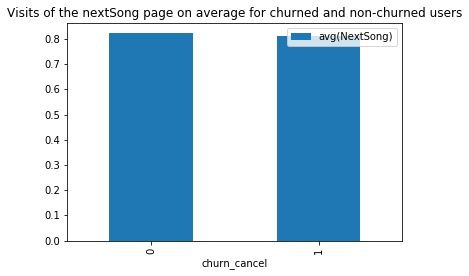

In [85]:
# Plot
df_songs.plot.bar(x='churn_cancel', y='avg(NextSong)');
plt.title('Visits of the nextSong page on average for churned and non-churned users');

Both type of users (those who have visited the confirmation cancellation site and those who not) have a similar distribution of the songs played. No great differences can be observed between both groups.

Let's have a look at these differences for each page.

In [56]:
# Create 0/1 colum for every page
for pag in df.select('page').dropDuplicates().toPandas().values.flatten():
    page_name = udf(lambda x: 1 if x == pag else 0, IntegerType())
    df = df.withColumn(pag, page_name(df.page))

df.head()

Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', churn_confirmation_cancellation=0, churn_submit_downgrade=0, churn_cancel=0, churn_downgrade=0, NextSong=1, Cancel=0, Submit Downgrade=0, Thumbs Down=0, Home=0, Downgrade=0, Roll Advert=0, Logout=0, Save Settings=0, Cancellation Confirmation=0, About=0, Settings=0, Add to Playlist=0, Add Friend=0, Thumbs Up=0, Help=0, Upgrade=0, Error=0, Submit Upgrade=0)

In [58]:
# See the distribution of visits to every page for churns
means_visits = df.select('churn_cancel', 'NextSong', 'Cancel','Submit Downgrade', 'Thumbs Down',\
                         'Home', 'Downgrade', 'Roll Advert', 'Logout', 'Save Settings',\
                         'Cancellation Confirmation', 'About', 'Settings',\
                         'Add to Playlist', 'Add Friend', 'Thumbs Up', 'Help',\
                         'Upgrade', 'Error', 'Submit Upgrade').groupby('churn_cancel').mean().toPandas()
means_visits

,churn_cancel,avg(churn_cancel),avg(NextSong),avg(Cancel),avg(Submit Downgrade),avg(Thumbs Down),avg(Home),avg(Downgrade),avg(Roll Advert),avg(Logout),avg(Save Settings),avg(Cancellation Confirmation),avg(About),avg(Settings),avg(Add to Playlist),avg(Add Friend),avg(Thumbs Up),avg(Help),avg(Upgrade),avg(Error),avg(Submit Upgrade)
0,0,0.0,0.821784,0.000000,0.000231,0.008787,0.036050,0.007364,0.012714,0.011458,0.001080,0.000000,0.001882,0.005332,0.023524,0.015607,0.045831,0.005208,0.001659,0.000943,0.000544
1,1,1.0,0.811207,0.001159,0.000201,0.011056,0.037268,0.007512,0.021554,0.012326,0.001293,0.001159,0.001248,0.006018,0.023137,0.014176,0.041436,0.005327,0.002496,0.000713,0.000713


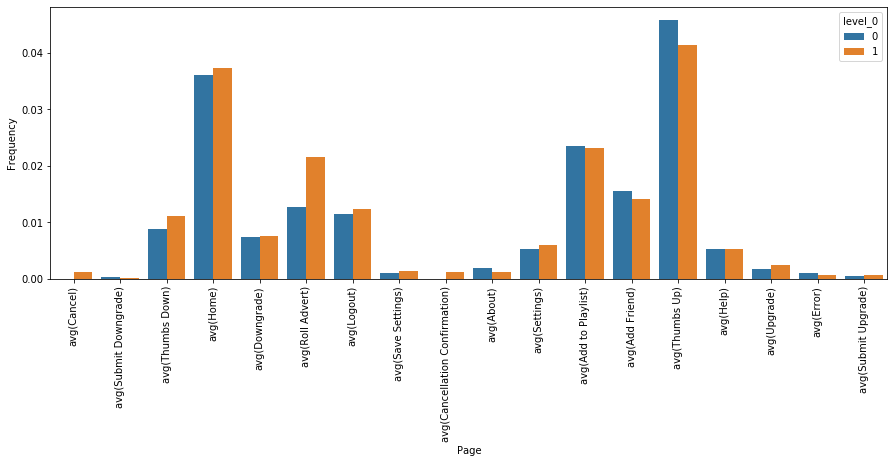

In [77]:
means_visits_plot = means_visits.T.unstack().reset_index(drop=False)
means_visits_plot = means_visits_plot[means_visits_plot.level_1 != 'churn_cancel']
means_visits_plot = means_visits_plot[means_visits_plot.level_1 != 'avg(churn_cancel)']
means_visits_plot = means_visits_plot[means_visits_plot.level_1 != 'avg(NextSong)']

plt.figure(figsize=(15,5))
sns.barplot(x='level_1', y = 0, hue='level_0', data=means_visits_plot, orient="v")
plt.xlabel('Page')
plt.ylabel('Frequency')
plt.xticks(rotation=90);

No great differences are observed between most of the pages. The greater differences are observed for the upgrade, cancellation confirmation, thumbs up and roll advert pages.

In [80]:
# See the gender for the churned and non-churned users
churn_gender = df.select('userId', 'gender', 'churn_cancel').dropDuplicates().groupby('churn_cancel', 'gender').count().toPandas()
churn_gender

,churn_cancel,gender,count
0,0,F,84
1,1,M,32
2,1,F,20
3,0,M,89


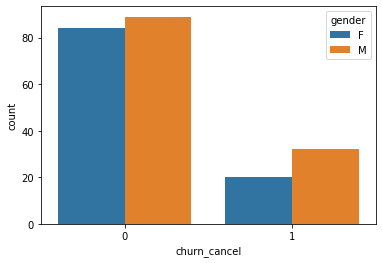

In [82]:
sns.barplot(x='churn_cancel', y= 'count', hue='gender', data =churn_gender);

In [91]:
# Let's compare ration between songs played and home visits
nextSong_home = df.where((df.page == 'NextSong') | (df.page == 'Home'))\
                  .groupBy('churn_cancel', 'page').count().toPandas()

In [102]:
# Churn_cancel = 0
result = []
result.append(nextSong_home[(nextSong_home.churn_cancel == 0) & (nextSong_home.page == 'NextSong')]\
                ['count'].values[0] / nextSong_home[(nextSong_home.churn_cancel == 0) & (nextSong_home.page == 'Home')]\
                ['count'].values[0])
            
print('Ratio between songs played and home visits (no churned): ', result[0])

# Churn_cancel = 1

result.append(nextSong_home[(nextSong_home.churn_cancel == 1) & (nextSong_home.page == 'NextSong')]\
            ['count'].values[0] / nextSong_home[(nextSong_home.churn_cancel == 1) & (nextSong_home.page == 'Home')]\
            ['count'].values[0])
            
print('Ratio between songs played and home visits (churned): ', result[1])

Ratio between songs played and home visits (no churned):  22.795957193816886
Ratio between songs played and home visits (churned):  21.766746411483254


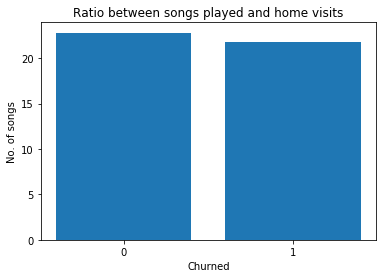

In [104]:
plt.bar(x=['0', '1'], height = result);
plt.title('Ratio between songs played and home visits')
plt.ylabel('No. of songs')
plt.xlabel('Churned');

In [168]:
# Let's have a look at the timestamps

# Define udfs
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000).hour, IntegerType())
get_weekday = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000).strftime("%w"))
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000).day, IntegerType())
get_month = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000).month, IntegerType())
get_year = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000).year, IntegerType())


# Create new columns
df = df.withColumn('hour', get_hour(df.ts))\
       .withColumn('weekday', get_weekday(df.ts))\
       .withColumn('day', get_day(df.ts))\
       .withColumn('month', get_month(df.ts))\
       .withColumn('year', get_year(df.ts))

df.collect()

[Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', churn_confirmation_cancellation=0, churn_submit_downgrade=0, churn_cancel=0, churn_downgrade=0, NextSong=1, Cancel=0, Submit Downgrade=0, Thumbs Down=0, Home=0, Downgrade=0, Roll Advert=0, Logout=0, Save Settings=0, Cancellation Confirmation=0, About=0, Settings=0, Add to Playlist=0, Add Friend=0, Thumbs Up=0, Help=0, Upgrade=0, Error=0, Submit Upgrade=0, hour=14, weekday='1', day=8, month=10, year=2018),
 Row(artist='Francesca Battistelli', auth='Logged In', firstName=

In [153]:
# Create a function to plot time series
def plot_interactions(grouping_unit, page_to_analyze = '', df = df):
    '''
    DESCRIPTION:
    Plot time series
    
    INPUT:
    grouping_unit unit: day, weekday or hour
    page_to_analyze (optional): page to analyze
    '''

    if page_to_analyze is '':
        interactions = df.select(grouping_unit, 'churn_cancel')\
                 .groupBy(grouping_unit, 'churn_cancel').count()\
                 .toPandas()
    
    else:
        interactions = df.where(df.page == page_to_analyze)\
                         .select(grouping_unit, 'churn_cancel')\
                         .groupBy(grouping_unit, 'churn_cancel').count()\
                         .toPandas()
    
    plt.figure(figsize=(15,5))
    sns.barplot(x = grouping_unit, y = 'count', hue='churn_cancel', data = interactions);

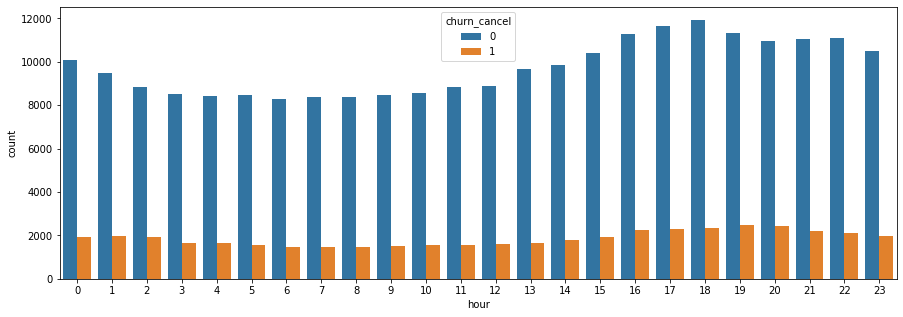

In [145]:
# Interaction per hour
plot_interactions('hour')

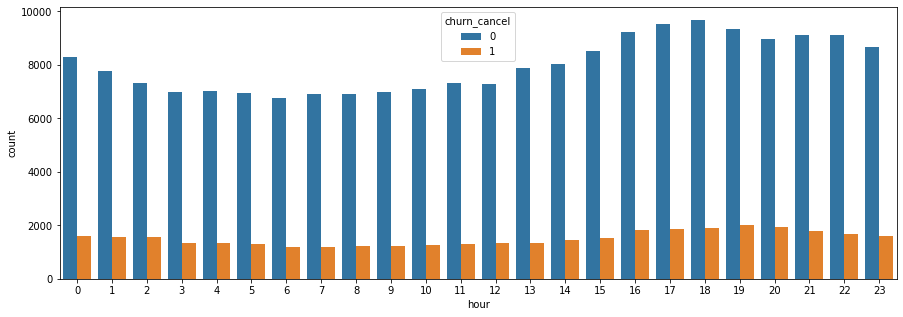

In [146]:
# Interaction NextSong per hour
plot_interactions('hour', 'NextSong')

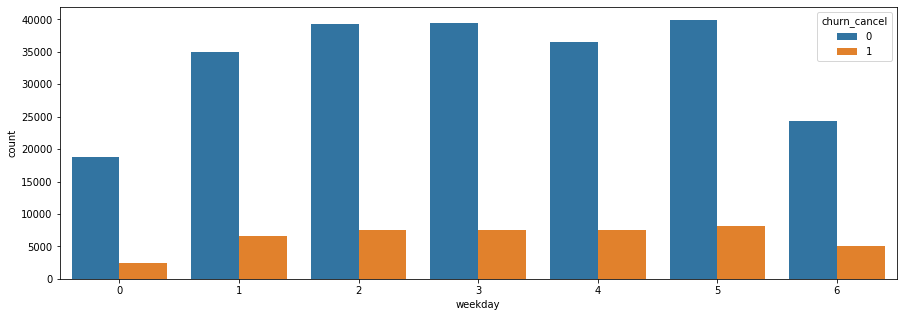

In [154]:
# Interaction per weekday
plot_interactions('weekday')

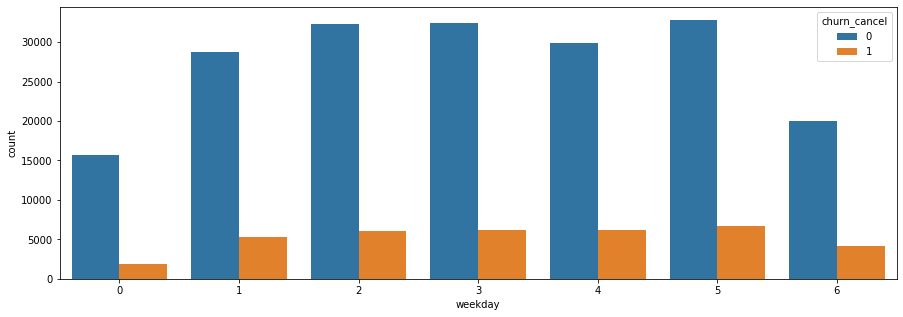

In [155]:
# Interaction NextSong per weekday
plot_interactions('weekday', 'NextSong')

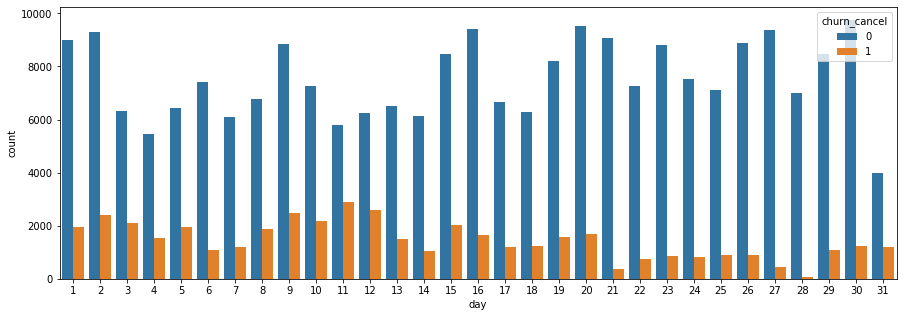

In [148]:
# Interaction per day
plot_interactions('day')

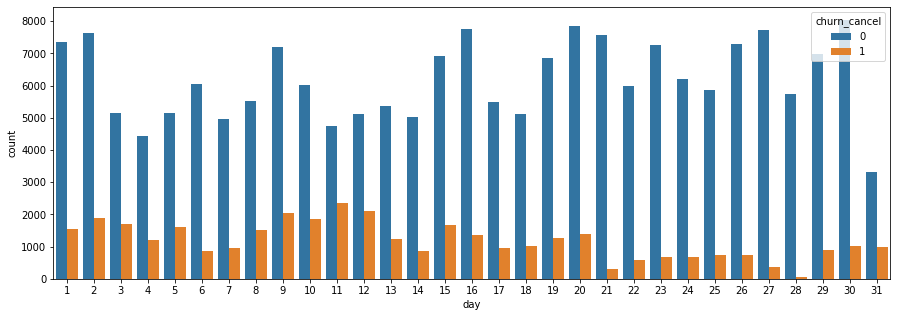

In [149]:
# Interaction NextSong per day
plot_interactions('day', 'NextSong')

No great differences are observed in the previous time series for the total no. of interactions and the interaction with the NextSong page. In both cases a similar distribution is observed.

Regarding the different grouping units, no great differences are observed when looking at the hour and weekday. However, if we have a look at the day of the month, a reduction of the interaction by the churned users is observed by the end of the month.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In the previous analysis, we could see that the time could be an important fact making the differences between both groups (churned and non-churned users). Thus, several time features are developed for the subsequent ML algorithm. At the same time, slightly differences are observed in the pages visited by each group. Finally, since we are talking about a music app, songs played and artists should be also part of the model.

With all this information, the following features are developed in this section:

- Time since registration
- Mean time per day
- Mean time per session
- Mean no. of songs played per session
- Mean no. of different artist played per session
- Mean no. of interactions per session
- Gender
- Status
- Type of user: free or pay
- Distribution of pages visits

### Time since registration
Difference between the registration timestamp and the last timestamp of the user.

In [164]:
# Find registration timestamp
registration = df.select('userId', 'registration')\
                 .where(df.registration.isNotNull()).dropDuplicates()
# Find last timestamp
last_timestamp = df.select('userId', 'ts')\
                   .groupBy('userId').max('ts')\
                   .withColumnRenamed('userId', 'userId2')
# Join both dfs
registration_timestamp = last_timestamp.join(registration, last_timestamp.userId2 == registration.userId)
# Compute delta
registration_timestamp = registration_timestamp.withColumn('delta_reg_last_time', (registration_timestamp['max(ts)'] - registration_timestamp['registration']))
# Show resulting df
registration_timestamp = registration_timestamp.select('userId', 'delta_reg_last_time')
registration_timestamp.show()

+------+-------------------+
|userId|delta_reg_last_time|
+------+-------------------+
|100010|         4807612000|
|200002|         6054448000|
|   125|         6161779000|
|   124|        11366431000|
|    51|         1680985000|
|     7|         6288035000|
|    15|         4882773000|
|    54|         9568946000|
|   155|         2035240000|
|100014|         7351206000|
|   132|         5779219000|
|   154|         2062544000|
|   101|         4662657000|
|    11|        10754921000|
|   138|         5756546000|
|300017|         6424576000|
|100021|         5593438000|
|    29|         5192990000|
|    69|         6171072000|
|   112|         7556771000|
+------+-------------------+
only showing top 20 rows



### Mean time per day
Group by the user and day, calculate timedelta between min and max stamp for each user and day. Finally, group by user and compute mean.

In [177]:
mean_time_per_day = df.select('userId', 'ts', 'day', 'month', 'year')\
                      .withColumn('day_month_year', concat(col('day'), lit('-'), col('month'), lit('-'), col('year')))\
                      .groupBy('userId', 'day_month_year').agg((Fmax(df.ts) - Fmin(df.ts)).alias('dayTime'))\
                      .groupBy('userId').mean('dayTime')
mean_time_per_day.show()

+------+--------------------+
|userId|        avg(dayTime)|
+------+--------------------+
|200002|          1.192425E7|
|100010|           9269000.0|
|   125|           1774000.0|
|   124| 3.540113888888889E7|
|     7|   5258428.571428572|
|    51|4.0652571428571425E7|
|    54|3.8904645161290325E7|
|    15|3.0667166666666668E7|
|   155|           2.85715E7|
|   154|           6641000.0|
|   132|2.4345363636363637E7|
|100014|1.1088833333333334E7|
|   101| 4.367007692307692E7|
|    11|           9892187.5|
|   138| 2.926842105263158E7|
|300017| 2.941495918367347E7|
|    29|3.9111896551724136E7|
|    69|2.3611166666666668E7|
|100021|           1.29136E7|
|    42|3.2183488888888888E7|
+------+--------------------+
only showing top 20 rows



### Mean time per session
Group by user and sessionId, compute timedelta between max and min ts and finally group again by the userId computing the mean.

In [178]:
mean_time_per_session = df.select('userId', 'ts', 'sessionId')\
                      .groupBy('userId', 'sessionId').agg((Fmax(df.ts) - Fmin(df.ts)).alias('sessionTime'))\
                      .groupBy('userId').mean('sessionTime')
mean_time_per_session.show()

+------+--------------------+
|userId|    avg(sessionTime)|
+------+--------------------+
|100010|           9269000.0|
|200002|            1.5984E7|
|   125|           1774000.0|
|    51|           5.23414E7|
|   124|3.4739655172413796E7|
|     7|   5258428.571428572|
|    54| 1.933737837837838E7|
|    15|            3.1697E7|
|   155|3.2914333333333332E7|
|100014|1.1088833333333334E7|
|   132|        2.99370625E7|
|   154|           6641000.0|
|   101|           4.90548E7|
|    11|           9682625.0|
|300017|1.3999444444444444E7|
|   138|           3.38536E7|
|    29| 2.194541176470588E7|
|    69|3.1601111111111112E7|
|100021|           1.29136E7|
|    42| 1.977376595744681E7|
+------+--------------------+
only showing top 20 rows



### Mean no. of songs played per session
Group by user and session Id, computing the no. of songs played, then group by the users and finally calculate the mean no. of songs

In [180]:
mean_songs_per_session = df.where(df.page == 'NextSong')\
                           .select('userId', 'sessionId')\
                           .groupBy('userId', 'sessionId').count()\
                           .groupBy('userId').mean('count')\
                           .withColumnRenamed('avg(count)', 'mean_songs')
mean_songs_per_session.show()

+------+------------------+
|userId|        mean_songs|
+------+------------------+
|100010|39.285714285714285|
|200002|              64.5|
|   125|               8.0|
|    51|             211.1|
|   124|145.67857142857142|
|     7|21.428571428571427|
|    54| 81.17142857142858|
|    15|136.71428571428572|
|   155|136.66666666666666|
|100014|42.833333333333336|
|   132|             120.5|
|   154|              28.0|
|   101|             179.7|
|    11|           40.4375|
|300017|59.540983606557376|
|   138|             138.0|
|    29| 89.05882352941177|
|    69|             125.0|
|100021|              46.0|
|    42| 87.14634146341463|
+------+------------------+
only showing top 20 rows



### Mean no. of different artists played per session
Group by user and session Id, computing the no. of different artists played, then group by the users and finally calculate the mean no. of artists

In [181]:
mean_artists_per_session = df.where(df.page == 'NextSong')\
                           .select('userId', 'sessionId', 'artist')\
                           .dropDuplicates()\
                           .groupBy('userId', 'sessionId').count()\
                           .groupBy('userId').mean('count')\
                           .withColumnRenamed('avg(count)', 'mean_artists')
mean_artists_per_session.show()

+------+------------------+
|userId|      mean_artists|
+------+------------------+
|100010| 38.57142857142857|
|200002|62.166666666666664|
|   125|               8.0|
|    51|             188.2|
|   124|            132.25|
|     7|              21.0|
|    54| 76.42857142857143|
|    15|128.07142857142858|
|   155|126.83333333333333|
|100014|              42.0|
|   132|            110.75|
|   154|              27.0|
|   101|             159.0|
|    11|              39.0|
|300017|57.049180327868854|
|   138|122.06666666666666|
|    29| 81.79411764705883|
|    69|115.66666666666667|
|100021|              43.6|
|    42|  82.8780487804878|
+------+------------------+
only showing top 20 rows



### Mean no. of interactions per session
Group by user and session id, compute row counts, then group by the users and calculate mean.

In [182]:
mean_interactions_per_session = df.select('userId', 'sessionId')\
                                  .groupBy('userId', 'sessionId').count()\
                                  .groupBy('userId').mean('count')\
                                  .withColumnRenamed('avg(count)', 'mean_inter')
mean_interactions_per_session.show()

+------+------------------+
|userId|        mean_inter|
+------+------------------+
|100010| 54.42857142857143|
|200002|              79.0|
|   125|              11.0|
|    51|             246.4|
|   124| 166.3793103448276|
|     7|28.714285714285715|
|    54| 92.89189189189189|
|    15|151.86666666666667|
|   155|             167.0|
|100014|51.666666666666664|
|   132|             144.0|
|   154|39.333333333333336|
|   101|             214.9|
|    11|              53.0|
|300017| 70.28571428571429|
|   138|             164.6|
|    29|105.97058823529412|
|    69|149.11111111111111|
|100021|              63.8|
|    42| 90.57446808510639|
+------+------------------+
only showing top 20 rows



### Gender
Transform the gender column in a binary one (0 or 1), including casting and drop duplicated userIds.

In [184]:
users_gender = df.select('userId', 'gender').dropDuplicates()\
                 .replace(['M', 'F'], ['0', '1'], 'gender')
users_gender = users_gender.select('userId', users_gender.gender.cast('int'))
users_gender.show()

+------+------+
|userId|gender|
+------+------+
|    44|     1|
|    46|     1|
|    41|     1|
|    72|     1|
|300023|     1|
|    39|     1|
|100010|     1|
|    40|     1|
|    94|     1|
|    35|     1|
|    75|     1|
|   116|     1|
|200001|     0|
|200020|     0|
|100008|     1|
|200015|     0|
|   100|     0|
|100006|     1|
|300005|     1|
|    25|     1|
+------+------+
only showing top 20 rows



### Status
Status 404 corresponds to the standard http error message, while status 200 means that everything was fine. Let's compute the ratio between them.

In [187]:
# Count status 404
users_status_404 = df.select('userId', 'status').where(df.status == 404)\
                 .groupBy('userId').count().withColumnRenamed('count', 'count404')
# Count status 200
users_status_200 = df.select('userId', 'status').where(df.status == 200)\
                 .groupBy('userId').count().withColumnRenamed('count', 'count200')\
                 .withColumnRenamed('userId', 'userId2')
# Join both dfs
user_status = users_status_404.join(users_status_200, users_status_200.userId2 == users_status_404.userId)
# Calculate ratio
user_status = user_status.withColumn('ratio404', col('count404')/col('count200'))
user_status = user_status.select('userId', 'ratio404')
user_status.show()

+------+--------------------+
|userId|            ratio404|
+------+--------------------+
|   124|0.001342882721575...|
|    51|4.370629370629370...|
|     7|  0.0053475935828877|
|    15| 9.42951438000943E-4|
|    54|3.155569580309246E-4|
|   155|0.003289473684210526|
|   132|0.001423149905123...|
|   101|0.001509813789632612|
|    11| 0.00129366106080207|
|   138| 4.37636761487965E-4|
|300017|0.001254705144291...|
|100021|0.006993006993006993|
|    69|0.003244120032441...|
|    42|0.001769911504424...|
|    73|0.002415458937198...|
|200010|0.003597122302158...|
|   113|0.001720183486238...|
|    30|6.071645415907711E-4|
|    59|0.004993757802746567|
|   139|0.002375296912114...|
+------+--------------------+
only showing top 20 rows



### Type of user: free or pay
Currently status of the user. Look for the last timestamp of each userId and transform the level column in a binary one (0 or 1), including casting. Finally, drop duplicated userIds.

In [193]:
# Find last ts for every user and possible level
user_level = df.groupBy('userId', 'level').max('ts')

# Find last ts for every user
user_last_time = df.groupBy('userId').max('ts')\
                   .withColumnRenamed('userId', 'userId2')\
                   .withColumnRenamed('max(ts)', 'last_time')

# Join both dataframes
user_level = user_level.join(user_last_time, [user_level.userId == user_last_time.userId2, user_level['max(ts)'] == user_last_time.last_time])
user_level = user_level.select('userId', 'level')

# Convert the column
user_level = user_level.replace(['free', 'paid'], ['0', '1'], 'level')
user_level = user_level.select('userId', user_level.level.cast('int'))
user_level.show()

+------+-----+
|userId|level|
+------+-----+
|200008|    1|
|    96|    1|
|200002|    1|
|    49|    1|
|    68|    0|
|    47|    0|
|200025|    1|
|300006|    1|
|100007|    1|
|    11|    1|
|    57|    0|
|100005|    0|
|300023|    1|
|   105|    1|
|100019|    0|
|    21|    1|
|   116|    0|
|    26|    1|
|     7|    0|
|   148|    0|
+------+-----+
only showing top 20 rows



### Distribution of pages visits
Use the columns created in the EDA with 0/1s for each page and group by user id aggregating with the mean.

In [195]:
pages_dist = df.select('userId', 'NextSong','Submit Downgrade', 'Thumbs Down',\
                       'Home', 'Downgrade', 'Roll Advert', 'Logout', \
                       'Save Settings', 'About', 'Settings','Add to Playlist', \
                       'Add Friend', 'Thumbs Up', 'Help', 'Upgrade', 'Error', \
                       'Submit Upgrade').groupBy('userId').mean()
pages_dist.show()

+------+------------------+---------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|userId|     avg(NextSong)|avg(Submit Downgrade)|    avg(Thumbs Down)|           avg(Home)|      avg(Downgrade)|    avg(Roll Advert)|         avg(Logout)|  avg(Save Settings)|          avg(About)|       avg(Settings)|avg(Add to Playlist)|     avg(Add Friend)|      avg(Thumbs Up)|           avg(Help)|        avg(Upgrade)|          avg(Error)| avg(Submit Upgrade)|
+------+------------------+---------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------

Once we have the different features, let's join all of them creating the final dataset.

In [214]:
# Create a list with all dfs
features_list = []
features_list.append(registration_timestamp)
features_list.append(mean_time_per_day)
features_list.append(mean_time_per_session)
features_list.append(mean_songs_per_session)
features_list.append(mean_artists_per_session)
features_list.append(mean_interactions_per_session)
features_list.append(users_gender)
features_list.append(user_status)
features_list.append(user_level)
features_list.append(pages_dist)

# Create df with userIds
df_features = df.select('userId').dropDuplicates()

In [220]:
# Function for merge
def join_df1_df2(df1, df2):
    '''
    DESCRIPTION:
    Merge two dataframes by the userid
    
    INPUT:
    df1, df2: dataframes to merge
    
    OUTPUT:
    df_final: merged dataframe
    '''
    df2 = df2.withColumnRenamed('userId', 'userId2')
    df_features = df1.join(df2, df1.userId == df2.userId2, 'left')\
                     .drop('userId2')
    
    return df_features

In [222]:
# Loop through the list to get the final df
for feat in features_list:
    df_features =  join_df1_df2(df_features, feat)

In [223]:
# Have a look at the schema of the df
df_features.printSchema()

root
 |-- userId: string (nullable = true)
 |-- delta_reg_last_time: long (nullable = true)
 |-- avg(dayTime): double (nullable = true)
 |-- avg(sessionTime): double (nullable = true)
 |-- mean_songs: double (nullable = true)
 |-- mean_artists: double (nullable = true)
 |-- mean_inter: double (nullable = true)
 |-- gender: integer (nullable = true)
 |-- ratio404: double (nullable = true)
 |-- level: integer (nullable = true)
 |-- avg(NextSong): double (nullable = true)
 |-- avg(Submit Downgrade): double (nullable = true)
 |-- avg(Thumbs Down): double (nullable = true)
 |-- avg(Home): double (nullable = true)
 |-- avg(Downgrade): double (nullable = true)
 |-- avg(Roll Advert): double (nullable = true)
 |-- avg(Logout): double (nullable = true)
 |-- avg(Save Settings): double (nullable = true)
 |-- avg(About): double (nullable = true)
 |-- avg(Settings): double (nullable = true)
 |-- avg(Add to Playlist): double (nullable = true)
 |-- avg(Add Friend): double (nullable = true)
 |-- avg(Th

In [224]:
# Create a df_labels with the churn column
df_labels = df.select('userId', 'churn_cancel').dropDuplicates()
df_labels.show()

+------+------------+
|userId|churn_cancel|
+------+------------+
|100010|           0|
|200002|           0|
|   125|           1|
|   124|           0|
|    51|           1|
|     7|           0|
|    15|           0|
|    54|           1|
|   155|           0|
|100014|           1|
|   132|           0|
|   154|           0|
|   101|           1|
|    11|           0|
|   138|           0|
|300017|           0|
|100021|           1|
|    29|           1|
|    69|           0|
|   112|           0|
+------+------------+
only showing top 20 rows



In [225]:
df_features.count()

225

In [229]:
# Merge features and labela
df_final = join_df1_df2(df_features, df_labels)
df_final.persist()

DataFrame[userId: string, delta_reg_last_time: bigint, avg(dayTime): double, avg(sessionTime): double, mean_songs: double, mean_artists: double, mean_inter: double, gender: int, ratio404: double, level: int, avg(NextSong): double, avg(Submit Downgrade): double, avg(Thumbs Down): double, avg(Home): double, avg(Downgrade): double, avg(Roll Advert): double, avg(Logout): double, avg(Save Settings): double, avg(About): double, avg(Settings): double, avg(Add to Playlist): double, avg(Add Friend): double, avg(Thumbs Up): double, avg(Help): double, avg(Upgrade): double, avg(Error): double, avg(Submit Upgrade): double, churn_cancel: bigint]

In [235]:
df_final.toPandas().to_csv('final_features_data.csv', header = True)

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [361]:
# Load data
df_final = spark.read.csv('final_features_data.csv', header=True)
df_final = df_final.drop('_c0').drop('userId')

In [362]:
df_final.toPandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   delta_reg_last_time    225 non-null    object
 1   avg(dayTime)           225 non-null    object
 2   avg(sessionTime)       225 non-null    object
 3   mean_songs             225 non-null    object
 4   mean_artists           225 non-null    object
 5   mean_inter             225 non-null    object
 6   gender                 225 non-null    object
 7   ratio404               117 non-null    object
 8   level                  225 non-null    object
 9   avg(NextSong)          225 non-null    object
 10  avg(Submit Downgrade)  225 non-null    object
 11  avg(Thumbs Down)       225 non-null    object
 12  avg(Home)              225 non-null    object
 13  avg(Downgrade)         225 non-null    object
 14  avg(Roll Advert)       225 non-null    object
 15  avg(Logout)            

All columns are complete except ratio404, which has 108 nans. Here we can infer a 0 for each nan. This were caused by the join done in the creation of this column. Since not every user has received a error message, some nans were generated in the join. 

In [363]:
# Fill nans
replace_none = udf(lambda x: 0 if x == None else x)
df_final = df_final.withColumn('ratio404_clean', replace_none('ratio404'))
df_final = df_final.drop('ratio404')
df_final = df_final.withColumnRenamed('ratio404_clean', 'ratio404')

In [364]:
# Rename label column
df_final = df_final.withColumnRenamed('churn_cancel', 'label')

In [365]:
# Columns
list_cols = df_final.columns
list_cols

['delta_reg_last_time',
 'avg(dayTime)',
 'avg(sessionTime)',
 'mean_songs',
 'mean_artists',
 'mean_inter',
 'gender',
 'level',
 'avg(NextSong)',
 'avg(Submit Downgrade)',
 'avg(Thumbs Down)',
 'avg(Home)',
 'avg(Downgrade)',
 'avg(Roll Advert)',
 'avg(Logout)',
 'avg(Save Settings)',
 'avg(About)',
 'avg(Settings)',
 'avg(Add to Playlist)',
 'avg(Add Friend)',
 'avg(Thumbs Up)',
 'avg(Help)',
 'avg(Upgrade)',
 'avg(Error)',
 'avg(Submit Upgrade)',
 'label',
 'ratio404']

In [366]:
# Parse all columns as floats
for col in list_cols:
    df_final = df_final.withColumn(col, df_final[col].cast('float'))

In [367]:
df_final.printSchema()

root
 |-- delta_reg_last_time: float (nullable = true)
 |-- avg(dayTime): float (nullable = true)
 |-- avg(sessionTime): float (nullable = true)
 |-- mean_songs: float (nullable = true)
 |-- mean_artists: float (nullable = true)
 |-- mean_inter: float (nullable = true)
 |-- gender: float (nullable = true)
 |-- level: float (nullable = true)
 |-- avg(NextSong): float (nullable = true)
 |-- avg(Submit Downgrade): float (nullable = true)
 |-- avg(Thumbs Down): float (nullable = true)
 |-- avg(Home): float (nullable = true)
 |-- avg(Downgrade): float (nullable = true)
 |-- avg(Roll Advert): float (nullable = true)
 |-- avg(Logout): float (nullable = true)
 |-- avg(Save Settings): float (nullable = true)
 |-- avg(About): float (nullable = true)
 |-- avg(Settings): float (nullable = true)
 |-- avg(Add to Playlist): float (nullable = true)
 |-- avg(Add Friend): float (nullable = true)
 |-- avg(Thumbs Up): float (nullable = true)
 |-- avg(Help): float (nullable = true)
 |-- avg(Upgrade): float

In [368]:
# Remove churn_cancel column
list_cols.remove('label')
list_cols

['delta_reg_last_time',
 'avg(dayTime)',
 'avg(sessionTime)',
 'mean_songs',
 'mean_artists',
 'mean_inter',
 'gender',
 'level',
 'avg(NextSong)',
 'avg(Submit Downgrade)',
 'avg(Thumbs Down)',
 'avg(Home)',
 'avg(Downgrade)',
 'avg(Roll Advert)',
 'avg(Logout)',
 'avg(Save Settings)',
 'avg(About)',
 'avg(Settings)',
 'avg(Add to Playlist)',
 'avg(Add Friend)',
 'avg(Thumbs Up)',
 'avg(Help)',
 'avg(Upgrade)',
 'avg(Error)',
 'avg(Submit Upgrade)',
 'ratio404']

In [369]:
# Put all features into a vector to normalize/standardize
assembler = VectorAssembler(inputCols = list_cols, outputCol = 'Features')
data = assembler.transform(df_final)

In [370]:
# Scale the features
scaler = StandardScaler(inputCol = "Features", outputCol = "ScaledFeatures")
scalermodel = scaler.fit(data)
data = scalermodel.transform(data)

In [371]:
# Select the relevant columns
data = data.select('label', 'ScaledFeatures')

In [372]:
# Separate the dataset into training and testing data
train, validation = data.randomSplit([0.9,0.1], seed=42)
train = train.persist()

In [373]:
# Define models
logic = LogisticRegression(featuresCol = 'ScaledFeatures', labelCol = 'label', 
                           maxIter = 10, regParam = 0.01)
random = RandomForestClassifier(featuresCol = 'ScaledFeatures', labelCol = 'label')
gbt = GBTClassifier(featuresCol = "ScaledFeatures", labelCol = 'label')

In [374]:
# Fit models
model_logic = logic.fit(train)
model_random = random.fit(train)
model_gbt = gbt.fit(train)

In [378]:
# Define function for the cacualtion of the f1-score or accuracy
def model_performance(model, valid, metric = 'f1'):
    '''
    DESCRIPTION
    calculate f1-score for a given model and validation data
    
    INPUT:
    model: ml model to evaluate
    valid: validation data
    
    OUTPUT:
    f1-score
    '''
    
    evaluator = MulticlassClassificationEvaluator(metricName = metric)
    pred = model.transform(valid)
    
    return evaluator.evaluate(pred)

In [379]:
# Evaluation of the results for the training data
print('Model performance in training data (F1-score)')
print('Logistic regression: ',model_performance(model_logic, train))
print('Random forest: ',model_performance(model_random, train))
print('GBT: ',model_performance(model_gbt, train))

Model performance in training data (F1-score)
Logistic regression:  0.8078112019083097
Random forest:  0.9092553836524732
GBT:  1.0


In [381]:
# Evaluation of the results for the training data
print('Model performance in training data (accuracy)')
print('Logistic regression: ',model_performance(model_logic, train, 'accuracy'))
print('Random forest: ',model_performance(model_random, train, 'accuracy'))
print('GBT: ',model_performance(model_gbt, train, 'accuracy'))

Model performance in training data (accuracy)
Logistic regression:  0.827906976744186
Random forest:  0.9162790697674419
GBT:  1.0


In [380]:
# Evaluation of the results for the validation data
print('Model performance in training data (F1-score)')
print('Logistic regression: ',model_performance(model_logic, validation))
print('Random forest: ',model_performance(model_random, validation))
print('GBT: ',model_performance(model_gbt, validation))

Model performance in training data (F1-score)
Logistic regression:  0.8862745098039215
Random forest:  0.6588235294117648
GBT:  0.9066666666666667


In [382]:
# Evaluation of the results for the validation data
print('Model performance in training data (accuracy)')
print('Logistic regression: ',model_performance(model_logic, validation, 'accuracy'))
print('Random forest: ',model_performance(model_random, validation,  'accuracy'))
print('GBT: ',model_performance(model_gbt, validation,  'accuracy'))

Model performance in training data (accuracy)
Logistic regression:  0.9
Random forest:  0.7
GBT:  0.9


# Conclusions
With the features chosen, we have obtain a relative good model using logistic regression and the GBT model, with F1-scores and accuracies close to 0.9.
In both cases, no optimization methods for the models have been used, while most of the parameters correspond to the standard ones. Thus, there is still some place for improvement of the models.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.